# Analyzing Ford GoBike System Data¶


###### Introduction¶


Ford GoBike is a regional public bicycle sharing system in the San Francisco Bay Area, California. Beginning operation in August 2013 as Bay Area Bike Share, the Ford GoBike system currently has over 2,600 bicycles in 262 stations across San Francisco, East Bay and San Jose. On June 28, 2017, the system officially launched as Ford GoBike in a partnership with Ford Motor Company.

The bikes are available for use 24 hours/day, 7 days/week, 365 days/year and riders have access to all bikes in the network when they become a member or purchase a pass.

##### Preliminary wrangling

In [1]:
# import all packages and set plots to be embedded inline

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
from requests import get
import datetime
import glob
import os
import math
import warnings
%matplotlib inline

In [2]:
df = pd.read_csv("201902-fordgobike-tripdata.csv")
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


##### Data Assessment

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

In [4]:
df.sample(15)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
105719,394,2019-02-13 21:19:50.3330,2019-02-13 21:26:25.2730,66.0,3rd St at Townsend St,37.778742,-122.392741,114.0,Rhode Island St at 17th St,37.764478,-122.402570,6562,Subscriber,1999.0,Female,No
61202,662,2019-02-20 17:51:29.9310,2019-02-20 18:02:32.5850,26.0,1st St at Folsom St,37.787290,-122.394380,116.0,Mississippi St at 17th St,37.764802,-122.394771,5474,Subscriber,1980.0,Other,No
41960,429,2019-02-22 18:00:56.1560,2019-02-22 18:08:06.1380,100.0,Bryant St at 15th St,37.767100,-122.410662,67.0,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,4609,Subscriber,1989.0,Male,No
146949,453,2019-02-07 08:20:42.4950,2019-02-07 08:28:16.0800,67.0,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,89.0,Division St at Potrero Ave,37.769218,-122.407646,1466,Subscriber,1975.0,Female,No
158689,985,2019-02-05 18:37:01.1430,2019-02-05 18:53:26.7700,20.0,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,74.0,Laguna St at Hayes St,37.776435,-122.426244,1916,Subscriber,1991.0,Female,No
49402,979,2019-02-21 21:40:04.7560,2019-02-21 21:56:23.9680,53.0,Grove St at Divisadero,37.775946,-122.437777,24.0,Spear St at Folsom St,37.789677,-122.390428,4981,Subscriber,1992.0,Male,No
97805,721,2019-02-15 08:31:06.9280,2019-02-15 08:43:08.6550,386.0,24th St at Bartlett St,37.752105,-122.419724,130.0,22nd St Caltrain Station,37.757288,-122.392051,6255,Subscriber,1993.0,Female,No
167352,234,2019-02-04 17:26:15.1840,2019-02-04 17:30:09.7430,27.0,Beale St at Harrison St,37.788059,-122.391865,17.0,Embarcadero BART Station (Beale St at Market St),37.792251,-122.397086,4369,Customer,1992.0,Male,No
9152,274,2019-02-28 07:44:43.6430,2019-02-28 07:49:17.9380,90.0,Townsend St at 7th St,37.771058,-122.402717,81.0,Berry St at 4th St,37.775880,-122.393170,5736,Subscriber,1992.0,Male,No
158033,1184,2019-02-05 19:44:57.3240,2019-02-05 20:04:41.6580,50.0,2nd St at Townsend St,37.780526,-122.390288,115.0,Jackson Playground,37.765026,-122.398773,762,Subscriber,1985.0,Male,No


In [5]:
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year
count,183412.000000,183215.000000,183412.000000,183412.000000,183215.000000,183412.000000,183412.000000,183412.000000,175147.000000
mean,726.078435,138.590427,37.771223,-122.352664,136.249123,37.771427,-122.352250,4472.906375,1984.806437
std,1794.389780,111.778864,0.099581,0.117097,111.515131,0.099490,0.116673,1664.383394,10.116689
min,61.000000,3.000000,37.317298,-122.453704,3.000000,37.317298,-122.453704,11.000000,1878.000000
25%,325.000000,47.000000,37.770083,-122.412408,44.000000,37.770407,-122.411726,3777.000000,1980.000000
50%,514.000000,104.000000,37.780760,-122.398285,100.000000,37.781010,-122.398279,4958.000000,1987.000000
75%,796.000000,239.000000,37.797280,-122.286533,235.000000,37.797320,-122.288045,5502.000000,1992.000000
max,85444.000000,398.000000,37.880222,-121.874119,398.000000,37.880222,-121.874119,6645.000000,2001.000000


In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
dtype: int64

###### Quality issues


1- fix multiple fields that are not in the correct dtype
2- add a new column calculating member  age from 'member_birth_year'
3- Extract and Create new columns for trip duration in minute, trip start date in yyyy-mm-dd format, trip start hour of the day, day of week and month
4- filter out outlier ages from visually examination of the distribution 

###### Cleaning Data

In [8]:
#create copy of data set
df_clean = df.copy()

In [9]:
df_clean.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


###### defind

fix multiple fields that are not in the correct dtype

In [10]:
#set start_time and end_time to timestamps
df_clean.start_time = pd.to_datetime(df_clean.start_time)
df_clean.end_time   = pd.to_datetime(df_clean.end_time)

# set bike id, start_station_id, end_station_id to object
df_clean.bike_id =df_clean.bike_id.astype('str')
df_clean.start_station_id =df_clean.start_station_id.astype('str')
df_clean.end_station_id =  df_clean.end_station_id.astype('str')



#set user type, member_gender and bike_share_for_all_trip to category
df_clean.user_type = df_clean.user_type.astype('category')
df_clean.member_gender =df_clean.member_gender.astype('category')
df_clean.bike_share_for_all_trip=df_clean.bike_share_for_all_trip.astype('category')




###### Test

In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             183412 non-null  int64         
 1   start_time               183412 non-null  datetime64[ns]
 2   end_time                 183412 non-null  datetime64[ns]
 3   start_station_id         183412 non-null  object        
 4   start_station_name       183215 non-null  object        
 5   start_station_latitude   183412 non-null  float64       
 6   start_station_longitude  183412 non-null  float64       
 7   end_station_id           183412 non-null  object        
 8   end_station_name         183215 non-null  object        
 9   end_station_latitude     183412 non-null  float64       
 10  end_station_longitude    183412 non-null  float64       
 11  bike_id                  183412 non-null  object        
 12  user_type       

###### defind    
calculating riders' age from 'member_birth_year'

In [12]:
df_clean['member_age']=2021-df_clean['member_birth_year']

###### Test

In [13]:
df_clean.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,member_age
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No,37.0
1,42521,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No,NaN
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No,49.0
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No,32.0
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes,47.0


###### defind
 Create new columns  for trip duration in minute, trip start date in yyyy-mm-dd format, trip start hour of the day, day of week and month

In [14]:
df_clean['duration_minute']= df_clean['duration_sec']/60
df_clean['start_date']     =df_clean.start_time.dt.strftime("%Y-%m-%d")
df_clean['start_hour_day'] =df_clean.start_time.dt.strftime("%H")
df_clean['start_day_week'] =df_clean.start_time.dt.strftime("%A")
df_clean['start_month'] =df_clean.start_time.dt.strftime("%B")

df_clean.head(10)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,user_type,member_birth_year,member_gender,bike_share_for_all_trip,member_age,duration_minute,start_date,start_hour_day,start_day_week,start_month
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,...,Customer,1984.0,Male,No,37.0,869.750000,2019-02-28,17,Thursday,February
1,42521,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,...,Customer,NaN,NaN,No,NaN,708.683333,2019-02-28,18,Thursday,February
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,...,Customer,1972.0,Male,No,49.0,1030.900000,2019-02-28,12,Thursday,February
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,...,Subscriber,1989.0,Other,No,32.0,608.166667,2019-02-28,17,Thursday,February
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,...,Subscriber,1974.0,Male,Yes,47.0,26.416667,2019-02-28,23,Thursday,February
5,1793,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,93.0,4th St at Mission Bay Blvd S,37.770407,-122.391198,323.0,Broadway at Kearny,37.798014,...,Subscriber,1959.0,Male,No,62.0,29.883333,2019-02-28,23,Thursday,February
6,1147,2019-02-28 23:55:35.104,2019-03-01 00:14:42.588,300.0,Palm St at Willow St,37.317298,-121.884995,312.0,San Jose Diridon Station,37.329732,...,Subscriber,1983.0,Female,No,38.0,19.116667,2019-02-28,23,Thursday,February
7,1615,2019-02-28 23:41:06.766,2019-03-01 00:08:02.756,10.0,Washington St at Kearny St,37.795393,-122.404770,127.0,Valencia St at 21st St,37.756708,...,Subscriber,1989.0,Male,No,32.0,26.916667,2019-02-28,23,Thursday,February
8,1570,2019-02-28 23:41:48.790,2019-03-01 00:07:59.715,10.0,Washington St at Kearny St,37.795393,-122.404770,127.0,Valencia St at 21st St,37.756708,...,Subscriber,1988.0,Other,No,33.0,26.166667,2019-02-28,23,Thursday,February
9,1049,2019-02-28 23:49:47.699,2019-03-01 00:07:17.025,19.0,Post St at Kearny St,37.788975,-122.403452,121.0,Mission Playground,37.759210,...,Subscriber,1992.0,Male,No,29.0,17.483333,2019-02-28,23,Thursday,February


<AxesSubplot:xlabel='member_age'>

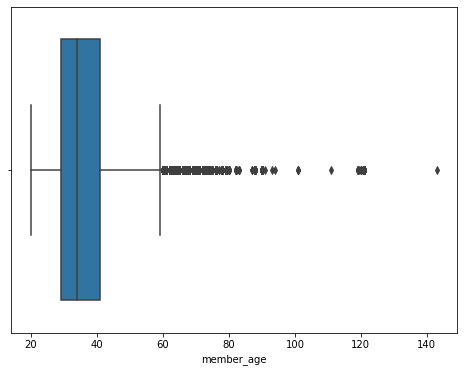

In [15]:
# plot the distribution of members' age
plt.figure(figsize=[8,6])
sns.boxplot(data=df_clean, x='member_age')

###### defind

filter out outlier ages from visually examination of the distribution above

In [16]:
df_clean['member_age'].mean()

36.19356312126385

In [17]:
df_clean['member_age'].describe(percentiles = [.99])
# So it looks like 75% of users are under the age of 40
## So it looks like 99% of users are under the age of 70

count    175147.000000
mean         36.193563
std          10.116689
min          20.000000
50%          34.000000
99%          66.000000
max         143.000000
Name: member_age, dtype: float64

In [18]:
df_clean=df_clean.query('member_age <= 70')
#remove all null value 

In [19]:
#change age and birth year to integer
df_clean.member_age = df_clean.member_age.astype(int)
df_clean.member_birth_year = df_clean.member_birth_year.astype(int)

In [20]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174295 entries, 0 to 183411
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174295 non-null  int64         
 1   start_time               174295 non-null  datetime64[ns]
 2   end_time                 174295 non-null  datetime64[ns]
 3   start_station_id         174295 non-null  object        
 4   start_station_name       174100 non-null  object        
 5   start_station_latitude   174295 non-null  float64       
 6   start_station_longitude  174295 non-null  float64       
 7   end_station_id           174295 non-null  object        
 8   end_station_name         174100 non-null  object        
 9   end_station_latitude     174295 non-null  float64       
 10  end_station_longitude    174295 non-null  float64       
 11  bike_id                  174295 non-null  object        
 12  user_type       

In [21]:
# save cleaned data 
df_clean.to_csv('master_Exploration_Ford_GoBike.csv', index=False)

###### What is the structure of your dataset?¶


The FordGoBike data is straightforward and intuitive to understand. This data has been collected efficiently, providing a valuable collection of data to work with and draw conclusions from.


 The dataset contained features about:
a) Trip duration: start_time,end_time, How long the trip took in seconds

b) Stations ID: start station id and end station id, name, geolocation (latitude/longitude)

d) member info (anonymized): bike_id, user_type, member_birth_year, member_gender, bike_share_for_all_trip

The dataset was further added few columns to find interesting analysis:

e) Bike time: month, day, hour of the day, weekday (both for start and end date)

f) customer: age       


I added the following columns in my cleaning :
1-  duration_minute                
2-  start_date                     
3- start_hour_day                 
4- start_day_week                 
5-  start_month  



###### What is/are the main feature(s) of interest in your dataset?¶


I am interested to know when the bikes are in high demand (during the day/weekdays/month). Second, what is the age of customers and gender (male/female) who mostly use the service. Finally, the service is mostly used by members or regular riders.

These features can be used to make business decisions such as what age group to target in marketing campaigns, or which day of the week bikes should be most available.

###### What features in the dataset do you think will help support your investigation into your feature(s) of interest?


Information about the start date/time and duration of each trip will help in understanding how long the trip usually takes and when.
   Member information such as user type, gender and age will help us know the main target customer groups 

##### Univariate Exploration

###### first explore the trips distribution over hour-of-day, day-of-week and month.

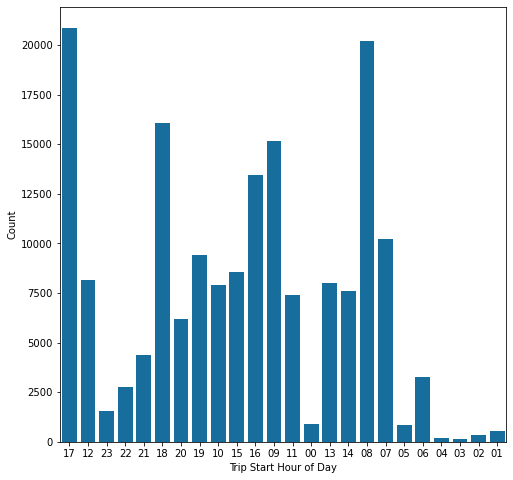

In [22]:
# trip distribution over day hours'
base_color = sns.color_palette('colorblind')[0]
plt.rcParams['figure.figsize'] = 8, 8
sns.countplot(data=df_clean, x='start_hour_day', color=base_color);
plt.xlabel('Trip Start Hour of Day');
plt.ylabel('Count');


The bikes saw the most usage during the morning hours of 7-8 am, and in the afternoon hours of 4-6pm

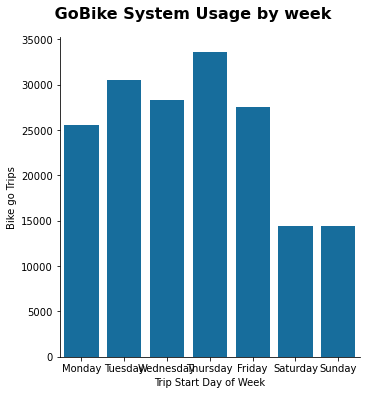

In [23]:
#trip  distribution  over week days

weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_day = sns.catplot(data=df_clean, x='start_day_week', kind='count', color = base_color, order = weekday)
week_day.set_axis_labels("Trip Start Day of Week", "Bike go Trips")
week_day.fig.suptitle(' GoBike System Usage by week', y=1.05, fontsize=16, fontweight='bold');

 it looks like Bike sharing is used mostly between Monday to Friday weekdays when compare to weekends
  Tuesdays and Wednesdays seem to be the most popular days for using the bike sharing system

In [24]:
df_clean.start_month.describe()

count       174295
unique           1
top       February
freq        174295
Name: start_month, dtype: object

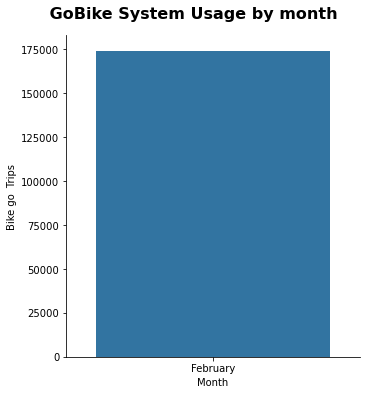

In [25]:
Month_plot = sns.catplot(data=df_clean, x='start_month', kind='count')
Month_plot.set_axis_labels("Month", "Bike go  Trips")
Month_plot.fig.suptitle('Trip Start Month', y=1.03, fontsize=14, fontweight='semibold');
Month_plot.fig.suptitle(' GoBike System Usage by month', y=1.05, fontsize=16, fontweight='bold');

The next  plots are around members/users



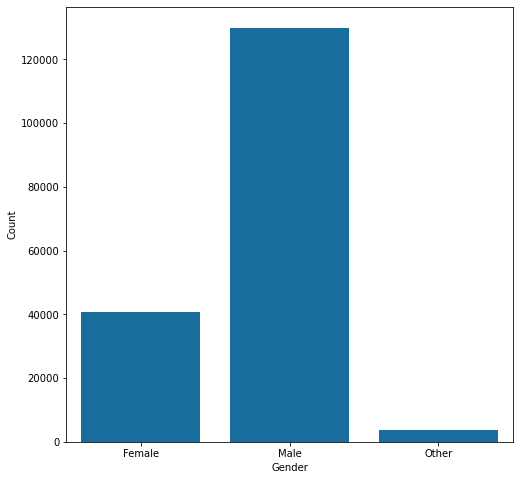

In [26]:
# member gender
sns.countplot(data=df_clean, x='member_gender', color=base_color);
plt.xlabel('Gender');
plt.ylabel('Count');

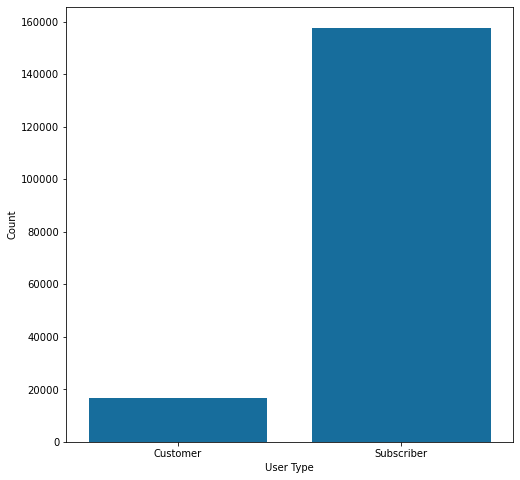

In [27]:
#user type
sns.countplot(data=df_clean, x='user_type', color=base_color);
plt.xlabel('User Type');
plt.ylabel('Count');

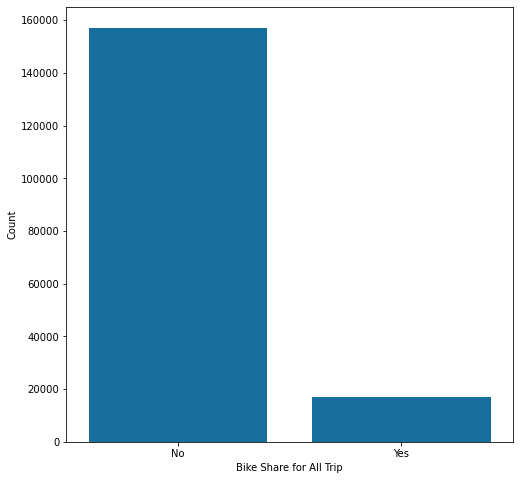

In [28]:
#Bike Share for All Trip
sns.countplot(data=df_clean, x='bike_share_for_all_trip', color=base_color);
plt.xlabel('Bike Share for All Trip');
plt.ylabel('Count');


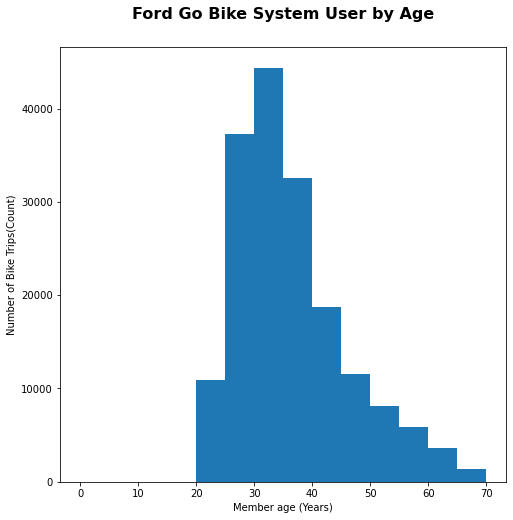

In [29]:
#Member Age
bin_edge = np.arange(0, df_clean['member_age'].max()+5, 5)

plt.hist(data = df_clean, x = 'member_age', bins = bin_edge);

plt.title("Ford Go Bike System User by Age", y=1.05, fontsize=16, fontweight='bold')
plt.xlabel('Member age (Years)')
plt.ylabel('Number of Bike Trips(Count)');


The average user age is 35.5 years.
   Most of the members were about 25 to 40 years old, which corresponded to the trip distribution charts that most trips took place Monday through Friday and peaked during peak hours of the day. With age, bicycle use decreased significantly.

Trip duration distribution 



In [30]:
df_clean['duration_minute'].describe(percentiles=[.99])


count    174295.000000
mean         11.742279
std          27.403204
min           1.016667
50%           8.516667
99%          52.966667
max        1409.133333
Name: duration_minute, dtype: float64

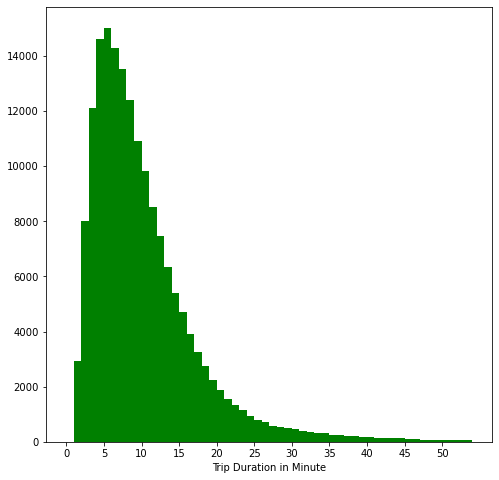

In [31]:

bins = np.arange(0, 55, 1)
ticks = np.arange(0, 55, 5)
plt.hist(data=df_clean, x='duration_minute', bins=bins,color="g");
plt.xticks(ticks, ticks);
plt.xlabel('Trip Duration in Minute');

It seem  99% of the trips were less than 1 hour long with most of them fell between 5 to 15 minutes range

note we can filter out outlier trip records where the duration was very long


###### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?¶


The number of trips peaked around 8-9 AM and 5-6 PM during the day, and there were more  trips s on working days (Monday-Friday) than on weekends.

From the user's point of view, there were more male riders than female riders, and more members were involved compared to regular riders. The majority of members did not use bike sharing on all of their rides, and most were between the ages of 25 and 40.

Most rounds were quick and short, lasting between 5-15 minutes, although there were some very long outliers like 24 hours.

###### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

I created new columns to calculate members' age, days of the week, months and hours for data analysis. 
ans i change column data types for some column
There was one uncommon distribution in the data set, that is, the member's year of birth had dates before 1900 and 95% of the members were between 17 and 57 years of age. To keep the data set simple, I removed members older than 70

### Bivariate Exploration
In this section, will investigate relationships between pairs of variables in the data.



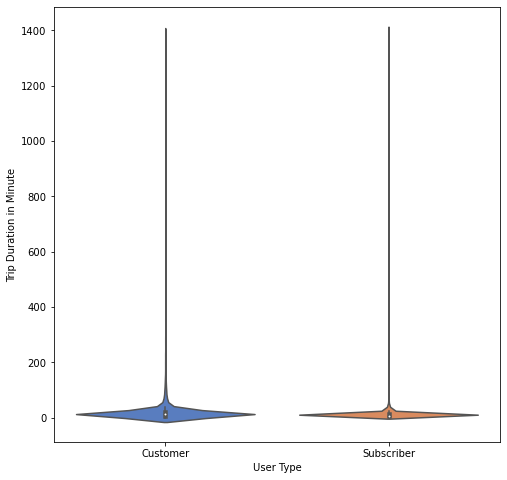

In [32]:
# explore into user type data analysis


# sns.boxplot(data= df_clean, x='user_type', y='duration_minute', color=base_color, palette="Set3",linewidth=2.5);
sns.violinplot(data=df_clean, x='user_type', y='duration_minute', color=base_color ,scale="width" ,palette="muted");

plt.xlabel('User Type');
plt.ylabel('Trip Duration in Minute');


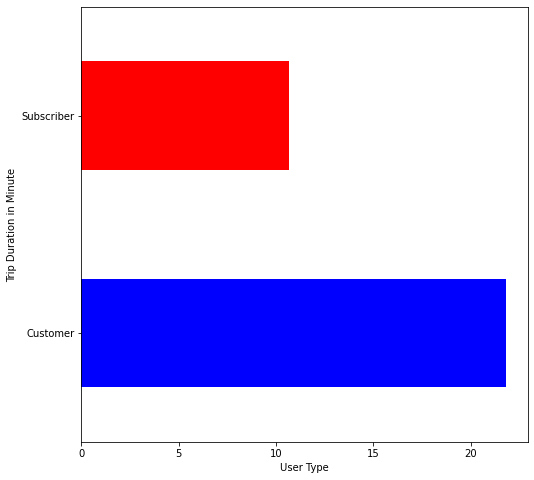

In [33]:
new_color=['blue', 'red']
ax = df_clean.groupby('user_type')['duration_minute'].mean().plot(kind='barh', color=new_color, figsize=(8,8))
plt.xlabel('User Type');
plt.ylabel('Trip Duration in Minute');

 Customers had longer trip duration more than 28 minutes when  Subscribers who took average trip duration around 12 mins.


 Customers vs Subscribers

In [34]:
customer = df_clean.query('user_type == "Customer"')['bike_id'].count()
subscriber = df_clean.query('user_type == "Subscriber"')['bike_id'].count()
prop_of_customer = customer / df_clean['bike_id'].count()
prop_of_subscriber = subscriber / df_clean['bike_id'].count()

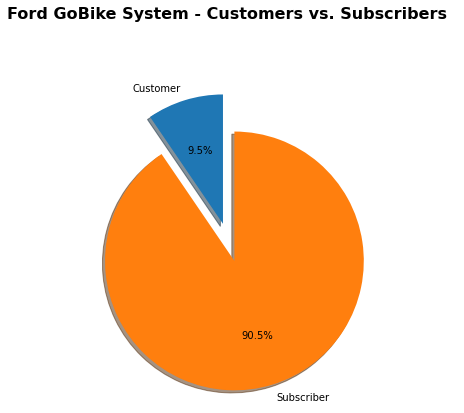

In [35]:
plt.figure(figsize = [8, 6])

labels = ['Customer', 'Subscriber']
size = [prop_of_customer, prop_of_subscriber]
explode = (0, 0.3)

plt.pie(size, explode=explode, labels = labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'color':'black'})
plt.axis('equal')

plt.suptitle('Ford GoBike System - Customers vs. Subscribers', y=1.05, fontsize=16, fontweight='bold');






90.5% of subscribers use a bike service compared to customers who use a bike service at 9.5%. This tells us that subscribers often use it for their daily commute and customers use it for more activities

###### weekly usage  by user type


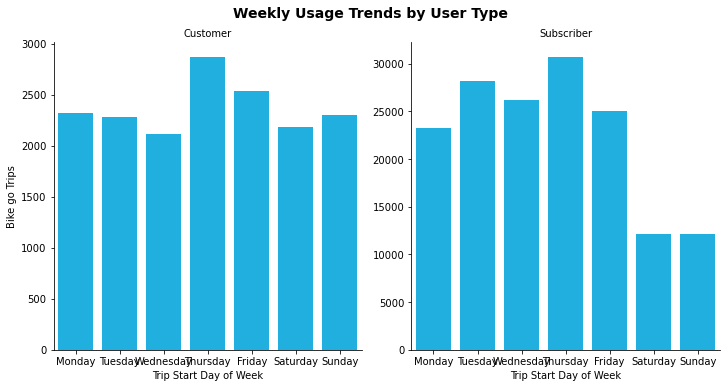

In [36]:
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_day = sns.catplot(data=df_clean, x='start_day_week', col="user_type", kind='count', sharey = False,
            color = 'deepskyblue', order = weekday)
week_day.set_axis_labels("Trip Start Day of Week", "Bike go Trips")
week_day.set_titles("{col_name}")
week_day.fig.suptitle('Weekly Usage Trends by User Type', y=1.03, fontsize=14, fontweight='semibold');



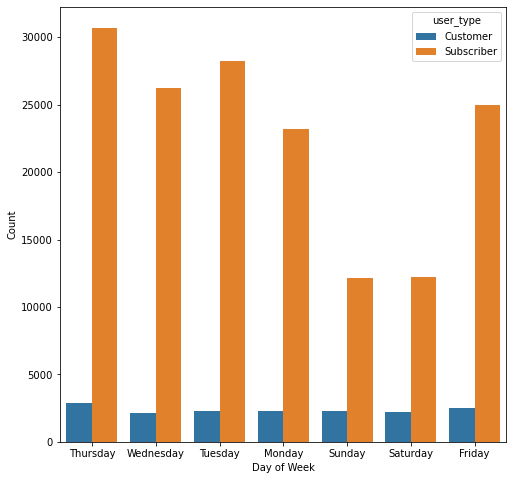

In [37]:

sns.countplot(data=df_clean, x='start_day_week', hue='user_type');
plt.xlabel('Day of Week');
plt.ylabel('Count');

Customers often use the service during weekends as subscribers mostly use the service during normal weekdays from Monday to Friday, this tells us that subscribers regularly use it for work and commuting from home and customers use it for fun activities during weekends.

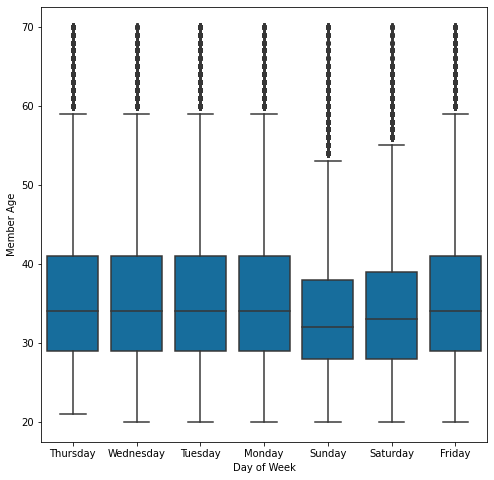

In [38]:
sns.boxplot(data=df_clean, x='start_day_week', y='member_age', color=base_color);
plt.xlabel('Day of Week');
plt.ylabel('Member Age');

Riders who rented the bikes Mon- Fri are older than those who ride on weekends, which agree to the commute to work usage

###### Hourly usage  by User type

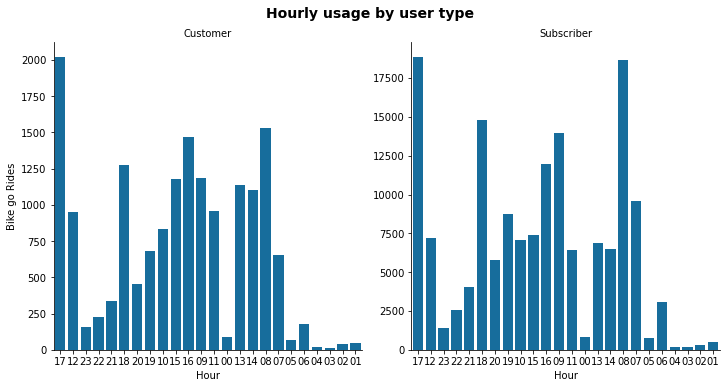

In [47]:
hour_usage= sns.catplot(data=df_clean, x='start_hour_day', col="user_type", kind='count', sharey = False,color=base_color
        )
hour_usage.set_axis_labels("Hour", "Bike go Rides")
hour_usage.set_titles("{col_name}")
hour_usage.fig.suptitle('Hourly usage by user type', y=1.03, fontsize=14, fontweight='semibold');

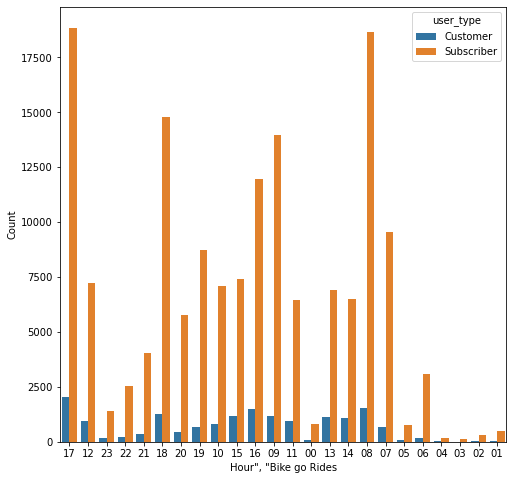

In [40]:
sns.countplot(data=df_clean, x='start_hour_day', hue='user_type');
plt.xlabel('Hour", "Bike go Rides');
plt.ylabel('Count');

Customers mostly use the service early morning around 7-8 am and   5-6pm where as subscribers mostly use the service between 8-9 am and 5-9 pm. 


Text(0, 0.5, 'Duration_sec')

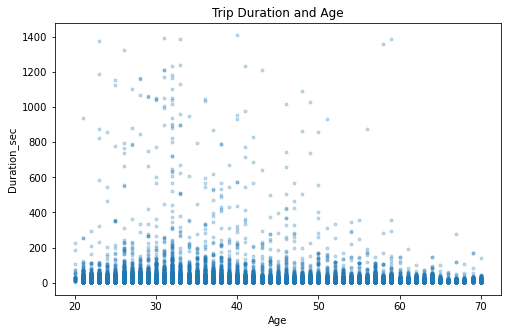

In [41]:
#Trip Duration and Age
plt.figure(figsize=[8,5])
plt.scatter(( df_clean['member_age']), df_clean['duration_minute'], alpha = 0.25, marker = '.' )

plt.title('Trip Duration and Age')
plt.xlabel('Age')
plt.ylabel('Duration_sec')


###### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

1- Subscribers use much more than customers.                                                                                  
2 - Subscribed users are slightly older than customer users who tend to take longer trips in general especially during summer.  
3 - Riding habit/style varies a lot between subscribers and customers.                                                        
4- Participants use the bicycle sharing system for work trips, and therefore most of the trips were on working days (from Monday to Friday), especially when going to work in the morning and getting off work in the afternoon                               
5- Customers tend to ride for fun in the afternoon or early evening during weekends.

###### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?¶


1-Customers took longer trip duration around 30-40 minutes to have more fun during weekends where as subscribers took shorter distance trips around 10mins                                                                                                   
2- subscribers are  older than customers

### Multivariate Exploration


How the three categorical measures of usertype and gender into the relationship between trip duration and age.

Text(0, 0.5, 'Duration_sec')

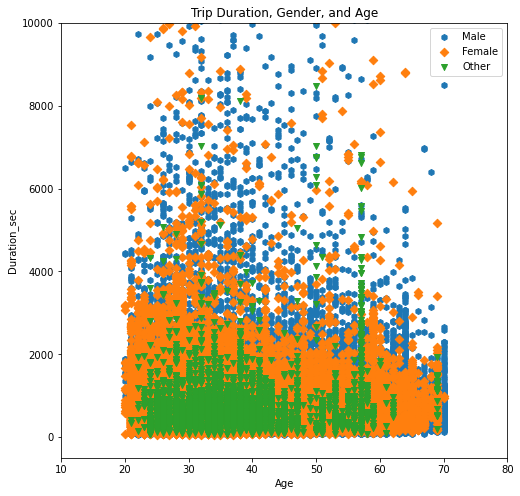

In [42]:
gender_mark = [['Male', 'h'],['Female', 'D'],['Other', 'v']]

for gender, marker in gender_mark:
    df_gender = df_clean[df_clean['member_gender'] == gender]
    plt.scatter((df_gender['member_age']), df_gender['duration_sec'], marker = marker, alpha= 1)
plt.legend(['Male','Female','Other'])
plt.axis([10, 80, -500, 10000 ])
plt.title('Trip Duration, Gender, and Age')
plt.xlabel('Age')
plt.ylabel('Duration_sec')


average trip duration vary in weekdays between customers and subscribers

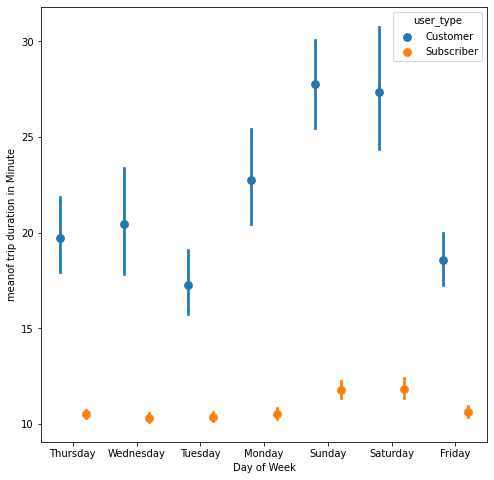

In [43]:
sns.pointplot(data=df_clean, x='start_day_week', y='duration_minute', hue='user_type', dodge=0.4, linestyles="");
plt.xlabel('Day of Week');
plt.ylabel('meanof trip duration in Minute');

 1- subscribers ride much shorter/quicker trips compared to customers on each day of the week.                                
2-   both subscribe and customer have an obvious increase of trip duration on Saturdays and Sundays over weekends

###### user type and  Gender

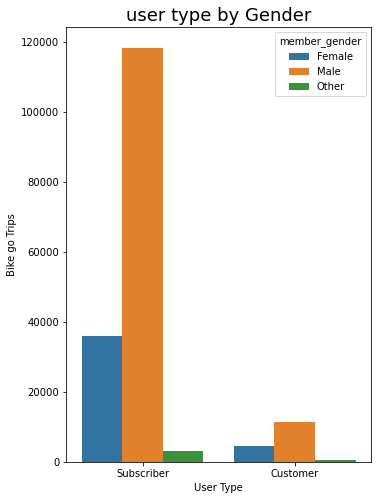

In [44]:

plt.figure(figsize = [12, 8])


plt.subplot(1, 2, 1)

gragh = sns.countplot(data=df_clean, x="user_type", hue="member_gender", order = df_clean.user_type.value_counts().index)
gragh.set_xlabel('User Type')
gragh.set_ylabel('Bike go Trips')
gragh.set_title('user type by Gender', y=1.00, fontsize=18);

 it looks like from both user types female are using service than male                                                          
that Most of the Males and Females (subscriber) utilizing more service or trips compare to Customer 

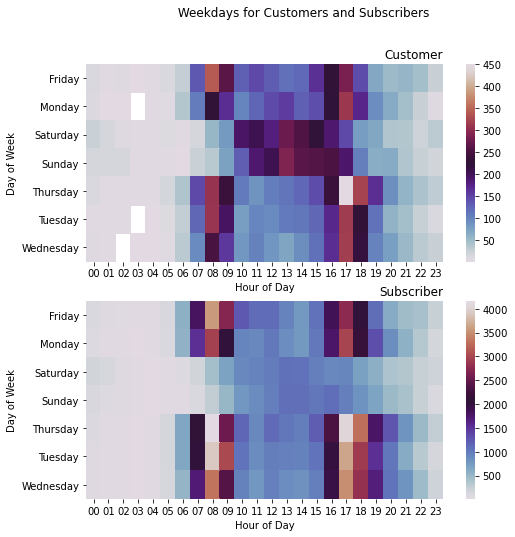

In [45]:
plt.suptitle( ' Weekdays for Customers and Subscribers')

plt.subplot(2, 1, 1)
customers = df_clean.query('user_type == "Customer"')
customer_cs = customers.groupby(['start_day_week', 'start_hour_day']).size()
customer_cs = customer_cs.reset_index(name='count')
customer_cs = customer_cs.pivot(index='start_day_week', columns='start_hour_day', values='count')
sns.heatmap(customer_cs, cmap='twilight');
plt.title('Customer', loc='right');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');

plt.subplot(2, 1, 2)
subscribers = df_clean.query('user_type == "Subscriber"')
subscribe_cs = subscribers.groupby(['start_day_week', 'start_hour_day']).size()
subscribe_cs  = subscribe_cs .reset_index(name='count')
subscribe_cs  = subscribe_cs .pivot(index='start_day_week', columns='start_hour_day', values='count')
sns.heatmap(subscribe_cs , cmap='twilight');
plt.title('Subscriber', loc='right');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');

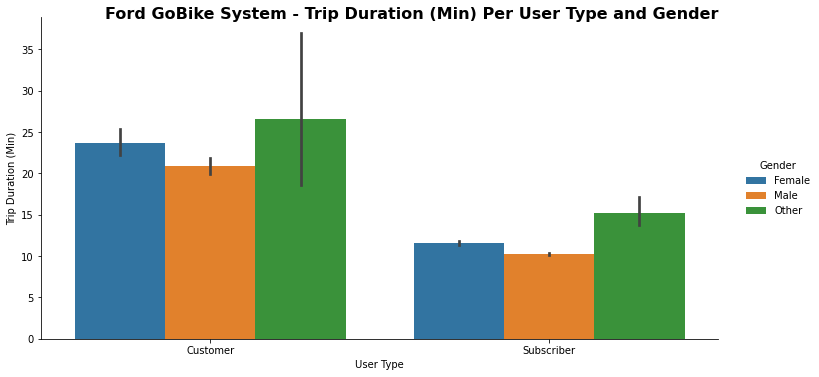

In [46]:
graph = sns.catplot(data=df_clean, x='user_type', y="duration_minute", hue="member_gender", kind ="bar",  height=5, aspect=2);

graph.set_axis_labels("User Type", "Trip Duration (Min)")
graph._legend.set_title('Gender')
graph.fig.suptitle('Ford GoBike System - Trip Duration (Min) Per User Type and Gender', y=1.0, fontsize=16, fontweight='bold');


Either way, females take longer flights than males and other races.
   The difference is more visible to customers where it is
13 minutes for males and 15 minutes more for females than participants

###### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

The features we looked at here are largely independent of each other. We didn't notice the features that reinforced each other in terms of looking at the features that matter to me.
The lifetime of the subscriber versus the customer has been extended through the use of age groups,
   Pointplot to show the changing habits of each age group.
The heat map did not reveal anything new to the time-based discussion of when and when each user group used the bike-sharing system. As mentioned earlier, customers use the system almost at the opposite time as subscribers

###### Summary


1- 90.5% of subscribers use bike service compared to customers who use bike service 9.5%. People use this service more on weekdays than on weekends
2- Cycling on Saturday and Sunday is longer than riding a bike on other days of the week.     

          
3- 2:00 AM has the fewest number of motorcyclists while 5:00 PM has the most number of motorcyclists.
        
4-Motorcycle drivers are more than male cyclists.

5- “Client” cyclists are taller on average compared to “common” cyclists.

6- In the age group 20-40 people who used the most service compared to other ages

7. Subscribers between 40-50 years old used the service more often on weekends than on weekdays


###### source

Seaborn catplot documentation  

Matplotlib histogram documentation

IPython Display documentation

Seaborn heatmap documentation and tutorial
